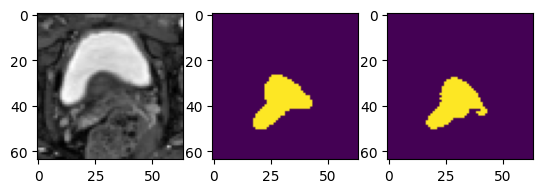

In [1]:
import random
from pathlib import Path

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import u_net
import utils

# to ensure reproducible training/validation split
random.seed(42)

# directorys with data and to stored training checkpoints
DATA_DIR = Path.cwd().parent.parent / "DevelopmentData"
CHECKPOINTS_DIR = Path.cwd() / "segmentation_model_weights" / f"u_net.pth"

# hyperparameters
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64, 64]

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE, valid=True)

unet_model = u_net.UNet(num_classes=1)
unet_model.load_state_dict(torch.load(CHECKPOINTS_DIR))
unet_model.eval()

with torch.no_grad():
    predict_index = 70
    (input, target) = valid_dataset[predict_index]
    output = torch.sigmoid(unet_model(input[np.newaxis, ...]))
    prediction = torch.round(output)

    plt.subplot(131)
    plt.imshow(input[0], cmap="gray")
    plt.subplot(132)
    plt.imshow(target[0])
    plt.subplot(133)
    plt.imshow(prediction[0, 0])
    plt.show()